In [19]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import deepxde as dde

from pathlib import Path
from scipy import optimize
from scipy.integrate import solve_ivp
from deepxde.backend import tf

sns.set_theme(style="darkgrid")

In [20]:
def phi(t, b, c):
    a = 1 / ((c / b) ** (b / (b - c)) - (c / b) ** (c / (b - c)))
    return a * (np.exp(-b * t) - np.exp(-c * t))

def dphi_dt(t, b, c):
    a = 1 / ((c / b) ** (b / (b - c)) - (c / b) ** (c / (b - c)))
    return a * (-b * np.exp(-b * t) + c * np.exp(-c * t))

def v_poly(t, v1, v2):
    return v1 * (1 - v2 / (v2 + t ** 4))

def dv_dt(t, v1, v2):
    return (4 * v1 * v2 * t ** 3) / ((v2 + t ** 4) ** 2)

def integral_dv_dphi(t, b, c, v1, v2):
    d_eta = 0.1
    eta_array = np.arange(d_eta, t + d_eta, d_eta)
    value = np.sum(dphi_dt(t - eta_array, b, c) * dv_dt(eta_array, v1, v2))
    return value * d_eta

vintegral_dv_dphi = np.vectorize(integral_dv_dphi)

def generate_data(
    t_array,
    y0,
):
    def func(t, y):
        S, E, I, A, Q, H, R, D = y
        dS_dt = -beta * S * (I + alpha * A) - integral_dv_dphi(t, phi_b, phi_c, v1, v2)
        dE_dt = beta * S * (I + alpha * A) - sigma * E
        dI_dt = r * sigma * E - (eta_1 + eta_2 + delta_I + mu_I) * I
        dA_dt = (1 - r) * sigma * E - delta_A * A
        dQ_dt = eta_1 * I - (xi + delta_Q) * Q
        dH_dt = eta_2 * I + xi * Q - (delta_H + mu_H) * H
        dR_dt = delta_I * I + delta_A * A + delta_H * H + delta_Q * Q
        dD_dt = mu_I * I + mu_H * H
        return np.array([dS_dt, dE_dt, dI_dt, dA_dt, dQ_dt, dH_dt, dR_dt, dD_dt])

    t_span = (t_array[0], t_array[-1])
    sol = solve_ivp(func, t_span, y0, t_eval=t_array)
    return sol.y.T

In [21]:
def tf_phi(t, b, c):
    a = 1 / ((c / b) ** (b / (b - c)) - (c / b) ** (c / (b - c)))
    return a * (tf.exp(-b * t) - tf.exp(-c * t))

def tf_dphi_dt(t, b, c):
    a = 1 / ((c / b) ** (b / (b - c)) - (c / b) ** (c / (b - c)))
    return a * (-b * tf.exp(-b * t) + c * tf.exp(-c * t))

def tf_v_poly(t, v1, v2):
    return v1 * (1 - v2 / (v2 + t ** 4))

def tf_dv_dt(t, v1, v2):
    return (4 * v1 * v2 * t ** 3) / ((v2 + t ** 4) ** 2)

In [22]:
# @tf.function
# def tf_integral_dv_dphi(t_tensor, b, c, v1, v2):
#     d_eta = tf.constant(0.1)
#     ta = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
#     ta = ta.unstack([0., 1.])
#     for i in range(n_days):
#         t = t_tensor[i]
#         eta_tensor = tf.range(d_eta, t + d_eta, d_eta)
#         value = tf.reduce_sum(tf_dphi_dt(t - eta_tensor, b, c) * tf_dv_dt(eta_tensor, v1, v2)) * d_eta
#         ta = ta.write(i, value)
#     return ta.stack()

In [23]:
# @tf.function
def tf_integral_dv_dphi(t_tensor, b, c, v1, v2):
  # value = tf.numpy_function(func=integral_dv_dphi, inp=[t_tensor, b, c, v1, v2], Tout=tf.float32)
  value = tf.py_function(func=vintegral_dv_dphi, inp=[t_tensor, b, c, v1, v2], Tout=tf.float32)
  return value

In [24]:
def dinn(
    data_t,
    data_y,
    parameters,
    hyperparameters
):

    # ODE model
    def ode(t, y):

        S = y[:, 0:1]
        E = y[:, 1:2]
        I = y[:, 2:3]
        A = y[:, 3:4]
        Q = y[:, 4:5]
        H = y[:, 5:6]
        R = y[:, 6:7]
        D = y[:, 7:8]

        dS_dt = dde.grad.jacobian(y, t, i=0)
        dE_dt = dde.grad.jacobian(y, t, i=1)
        dI_dt = dde.grad.jacobian(y, t, i=2)
        dA_dt = dde.grad.jacobian(y, t, i=3)
        dQ_dt = dde.grad.jacobian(y, t, i=4)
        dH_dt = dde.grad.jacobian(y, t, i=5)
        dR_dt = dde.grad.jacobian(y, t, i=6)
        dD_dt = dde.grad.jacobian(y, t, i=7)

        return [
            dS_dt - (-beta * S * (I + alpha * A) - tf_integral_dv_dphi(t, phi_b, phi_c, v1, v2)),
            dE_dt - (beta * S * (I + alpha * A) - sigma * E),
            dI_dt - (r * sigma * E - (eta_1 + eta_2 + delta_I + mu_I) * I),
            dA_dt - ((1 - r) * sigma * E - delta_A * A),
            dQ_dt - (eta_1 * I - (xi + delta_Q) * Q),
            dH_dt - (eta_2 * I + xi * Q - (delta_H + mu_H) * H),
            dR_dt - (delta_I * I + delta_A * A + delta_H * H + delta_Q * Q),
            dD_dt - (mu_I * I + mu_H * H)
        ]

    # Geometry
    geom = dde.geometry.TimeDomain(data_t[0, 0], data_t[-1, 0])

    # Boundaries
    def boundary(_, on_initial):
        return on_initial

    # Initial conditions
    S0, E0, I0, A0, Q0, H0, R0, D0 = data_y[0, :]
    ic_S = dde.icbc.IC(geom, lambda x: S0, boundary, component=0)
    ic_E = dde.icbc.IC(geom, lambda x: E0, boundary, component=1)
    ic_I = dde.icbc.IC(geom, lambda x: I0, boundary, component=2)
    ic_A = dde.icbc.IC(geom, lambda x: A0, boundary, component=3)
    ic_Q = dde.icbc.IC(geom, lambda x: Q0, boundary, component=4)
    ic_H = dde.icbc.IC(geom, lambda x: H0, boundary, component=5)
    ic_R = dde.icbc.IC(geom, lambda x: R0, boundary, component=6)
    ic_D = dde.icbc.IC(geom, lambda x: D0, boundary, component=7)

    # Model
    data = dde.data.PDE(
        geom,
        ode,
        [
            ic_S,
            ic_E,
            ic_I,
            ic_A,
            ic_Q,
            ic_H,
            ic_R,
            ic_D,
        ],
        num_domain=512,
        num_boundary=2,
        # train_distribution="uniform",
        # anchors=data_t,
    )

    neurons = hyperparameters["neurons"]
    layers = hyperparameters["layers"]
    activation = hyperparameters["activation"]
    net = dde.nn.FNN([1] + [neurons] * layers + [8], activation, "Glorot uniform")

    # def feature_transform(t):
    #     t = t / data_t[-1, 0]
    #     return t
    def feature_transform(t):
        t = t / data_t[-1, 0]
        return tf.concat(
            (
                t,
                tf.sin(t),
                tf.sin(2 * t),
                tf.sin(3 * t),
                tf.sin(4 * t),
                tf.sin(5 * t),
                tf.sin(6 * t),
            ),
            axis=1,
        )

    net.apply_feature_transform(feature_transform)

    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-4,
        loss_weights=hyperparameters["loss_weights"]
    )

    losshistory, train_state = model.train(
        iterations=hyperparameters["iterations"],
        display_every=10000
    )
    model.compile("L-BFGS")
    losshistory, train_state = model.train()
    dde.saveplot(losshistory, train_state, issave=False, isplot=True)

    return model, losshistory, train_state

In [25]:
N = 1453477594
S0 = (N - 1) / N
E0 = 0
I0 = 1 / N
A0 = 0
Q0 = 0
H0 = 0
R0 = 0
D0 = 0
y0 = [S0, E0, I0, A0, Q0, H0, R0, D0]

beta = 11
sigma = 1 / 4.35
r = 0.227
alpha = 0.43
eta_1 = 0.001
eta_2 = 0.0689
xi = 0.3
delta_I = 0.9975
mu_I = 0.0025
delta_A = 0.9975
delta_H = 0.9975
mu_H = 0.0015
delta_Q = 0.9975
phi_b = 0.231
phi_c = 0.008
v1 = 9.04733394e-01
v2 = 1.16081503e+09

parameters_real = {
    "beta": beta,
    # "sigma": sigma,
    # "r": r,
    # "alpha": alpha,
    # "eta_1": eta_1,
    # "eta_2": eta_2,
    # "xi": xi,
    # "delta_I": delta_I,
    # "mu_I": mu_I,
    # "delta_A": delta_A,
    # "delta_H": delta_H,
    # "mu_H": mu_H,
    # "delta_Q": delta_Q,
    # "phi_b": phi_b,
    # "phi_c": phi_c,
}

hyperparameters = {
    "search_range": (0.2, 1.8),
    "iterations": 30000,
    "layers": 5,
    "neurons": 64,
    "activation": "tanh",
    "loss_weights": [
        1, 1, 1, 1, 1, 1, 1, 1,
        100, 100, 1, 1, 1, 1, 100, 1
    ]
}

Compiling model...
Building feed-forward neural network...
'build' took 0.049487 s



2023-05-27 20:22:50.372293: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-27 20:22:50.372415: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-27 20:22:50.372445: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-27 20:22:50.373012: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-27 20:22:50.373037: I tensorflow/core/co

'compile' took 1.775751 s

Initializing variables...
Training model...



2023-05-27 20:23:02.899824: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion_2', 32764 bytes spill stores, 37836 bytes spill loads



0         [1.34e+00, 1.38e+00, 9.63e-02, 1.37e-01, 1.97e-01, 3.27e-01, 1.60e-01, 9.49e-04, 1.00e+02, 0.00e+00, 4.73e-19, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    [1.34e+00, 1.38e+00, 9.63e-02, 1.37e-01, 1.97e-01, 3.27e-01, 1.60e-01, 9.49e-04, 1.00e+02, 0.00e+00, 4.73e-19, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  


2023-05-27 20:23:09.085313: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion_20', 68 bytes spill stores, 40 bytes spill loads



10000     [1.19e-05, 2.89e-06, 1.51e-05, 5.25e-06, 9.48e-07, 1.03e-06, 1.48e-06, 1.92e-08, 4.18e-08, 4.88e-06, 9.38e-07, 2.12e-07, 1.36e-08, 5.83e-09, 2.36e-07, 1.67e-08]    [1.19e-05, 2.89e-06, 1.51e-05, 5.25e-06, 9.48e-07, 1.03e-06, 1.48e-06, 1.92e-08, 4.18e-08, 4.88e-06, 9.38e-07, 2.12e-07, 1.36e-08, 5.83e-09, 2.36e-07, 1.67e-08]    []  
20000     [1.71e-06, 1.16e-05, 1.26e-05, 3.55e-06, 4.78e-07, 6.48e-07, 1.13e-06, 1.03e-08, 2.34e-05, 2.64e-07, 8.94e-07, 3.51e-07, 3.36e-10, 1.15e-08, 7.56e-06, 2.55e-09]    [1.71e-06, 1.16e-05, 1.26e-05, 3.55e-06, 4.78e-07, 6.48e-07, 1.13e-06, 1.03e-08, 2.34e-05, 2.64e-07, 8.94e-07, 3.51e-07, 3.36e-10, 1.15e-08, 7.56e-06, 2.55e-09]    []  
30000     [2.39e-05, 6.76e-05, 8.25e-06, 2.37e-06, 1.93e-07, 2.95e-07, 3.69e-06, 1.09e-08, 3.47e-07, 9.38e-08, 1.17e-06, 1.76e-07, 3.56e-08, 1.26e-09, 6.12e-06, 8.57e-09]    [2.39e-05, 6.76e-05, 8.25e-06, 2.37e-06, 1.93e-07, 2.95e-07, 3.69e-06, 1.09e-08, 3.47e-07, 9.38e-08, 1.17e-06, 1.76e-07, 3.56e-08, 1.26e-09,

2023-05-27 20:31:11.926513: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion_2', 32764 bytes spill stores, 37836 bytes spill loads



Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
30000     [2.39e-05, 6.76e-05, 8.25e-06, 2.37e-06, 1.93e-07, 2.95e-07, 3.69e-06, 1.09e-08, 3.47e-09, 9.38e-10, 1.17e-06, 1.76e-07, 3.56e-08, 1.26e-09, 6.12e-08, 8.57e-09]    [2.39e-05, 6.76e-05, 8.25e-06, 2.37e-06, 1.93e-07, 2.95e-07, 3.69e-06, 1.09e-08, 3.47e-09, 9.38e-10, 1.17e-06, 1.76e-07, 3.56e-08, 1.26e-09, 6.12e-08, 8.57e-09]    []  


2023-05-27 20:31:18.530764: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion_29', 68 bytes spill stores, 40 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'fusion_43', 376 bytes spill stores, 232 bytes spill loads



INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000027
  Number of iterations: 8
  Number of functions evaluations: 32
30032     [2.80e-06, 4.44e-06, 1.42e-05, 3.51e-06, 1.97e-07, 2.53e-07, 5.11e-07, 9.64e-09, 3.26e-10, 1.10e-11, 8.68e-07, 1.82e-07, 9.38e-09, 7.08e-10, 5.16e-08, 2.90e-09]    [2.80e-06, 4.44e-06, 1.42e-05, 3.51e-06, 1.97e-07, 2.53e-07, 5.11e-07, 9.64e-09, 3.26e-10, 1.10e-11, 8.68e-07, 1.82e-07, 9.38e-09, 7.08e-10, 5.16e-08, 2.90e-09]    []  

Best model at step 30032:
  train loss: 2.70e-05
  test loss: 2.70e-05
  test metric: []

'train' took 19.639695 s



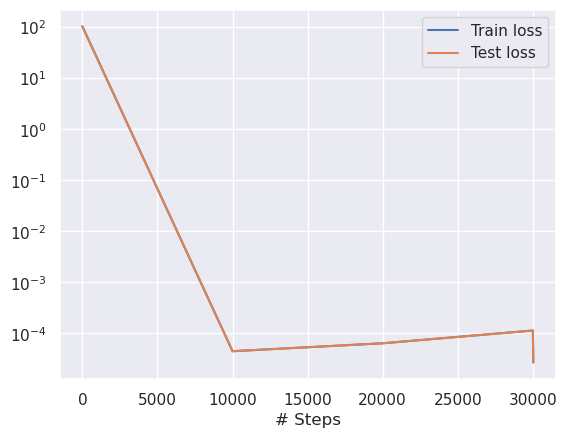

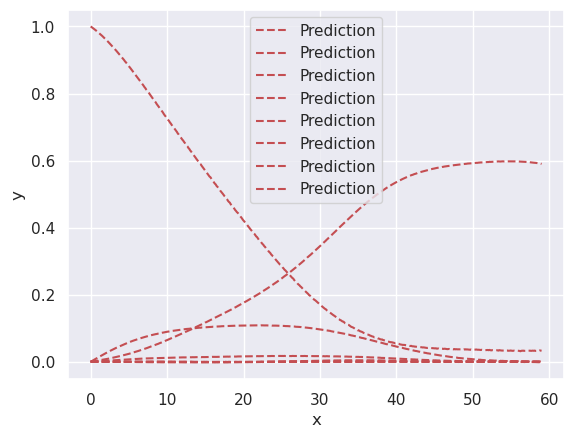

In [26]:
n_days = 60
t_train = np.arange(n_days)[:, np.newaxis]
y_train = generate_data(t_train.ravel(), y0)

model, losshistory, train_state = dinn(
    data_t=t_train,
    data_y=y_train,
    parameters=parameters_real,
    hyperparameters=hyperparameters
)
y_pred = model.predict(t_train)

In [27]:
model_name = "SEIAQHRD"
populations_names = list(model_name)
data_real = (
    pd.DataFrame(y_train, columns=populations_names, index=t_train.ravel())
    .rename_axis("time")
    .reset_index()
    .melt(id_vars="time", var_name="status", value_name="population")
)
data_pred = (
    pd.DataFrame(y_pred, columns=populations_names, index=t_train.ravel())
    .rename_axis("time")
    .reset_index()
    .melt(id_vars="time", var_name="status", value_name="population")
)

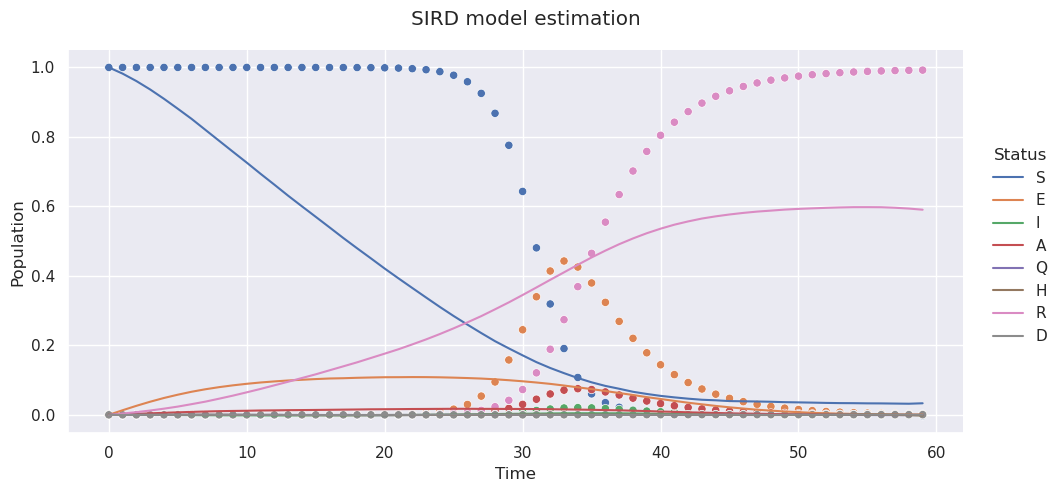

In [28]:
g = sns.relplot(
    data=data_pred,
    x="time",
    y="population",
    hue="status",
    kind="line",
    aspect=2,
)

sns.scatterplot(
    data=data_real,
    x="time",
    y="population",
    hue="status",
    ax=g.ax,
    legend=False
)

(
    g.set_axis_labels("Time", "Population")
    .tight_layout(w_pad=1)
)

g._legend.set_title("Status")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle(f"SIRD model estimation")
plt.show()